<a href="https://colab.research.google.com/github/jakubkarczewski/KaggleNotebooks/blob/master/nyc_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_path = "/content/gdrive/My Drive/models"
# !rm -rf "/content/gdrive/My Drive/models"



In [0]:
!cp -a "/content/gdrive/My Drive/nyc_taxi/train.pkl" "/content/train.pkl"
!cp -a "/content/gdrive/My Drive/nyc_taxi/test.csv" "/content/test.csv"
# !mkdir "/content/gdrive/My Drive/models"

In [0]:
# imports and tf session init
from time import time
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras import backend, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def init_session():
    tf_config = tf.ConfigProto()
    tf_config.allow_soft_placement = True
    tf_config.gpu_options.allow_growth = True
    tf_config.gpu_options.visible_device_list = str(0)
    sess=tf.Session(config=tf_config)

    keras.backend.set_session(sess)

init_session()


In [0]:
def clean_df(df):
    """Cleans data in df from invalid data and outliers"""
    
    df = df.dropna(how = 'any', axis = 'rows')
   
    df = df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
    df = df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
    df = df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df = df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]

    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]

    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df

In [0]:
def late_night(row):
    """Check if ride was late at night."""
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night(row):
    """Check if ride was at night on a weekday. Weird feature but improves."""
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0

      
def weekend(row):
    """Check if ride was on weekend."""
    if row['weekday'] > 4:
        return 1
    else:
        return 0

In [0]:
def manhattan(x_1, y_1, x_2, y_2):
    """Compute Manhattan distance for 2 points"""
    return np.abs(x_2 - x_1) + np.abs(y_2 - y_1)

In [0]:
def add_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].replace(" UTC", "")
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],
                                           format='%Y-%m-%d %H:%M:%S')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    df['weekend'] = df.apply(lambda x: weekend(x), axis=1)
    
    def encode(data, col, max_val):
        """Encodes time as a circular pattern."""
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data

    df = encode(df, 'month', 12)
    df = encode(df, 'day', 30.5)
    df = encode(df, 'hour', 60)
    df = encode(df, 'weekday', 7)

    df = df.drop('pickup_datetime', axis=1)

    return df

In [0]:
def add_coordinate_features(df):
    """Computes diff in lon and lat."""
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)

    return df

In [0]:
def add_distances_features(df):
    """Adds distance features"""
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], lat2, lon2)
    
    return df

In [0]:
start = time()

df_train = pd.read_pickle('./train.pkl')
df_test = pd.read_csv('./test.csv')
print('Data read. 1/6')

df_train = clean_df(df_train)
print('Data cleaned. 2/6')

df_train = add_coordinate_features(df_train)
df_test = add_coordinate_features(df_test)
print('Coords features added. 3/6')

df_train = add_distances_features(df_train)
df_test = add_distances_features(df_test)
print('Distance features added. 4/6')

dropped_columns = ['pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude']

df_train = df_train.drop(dropped_columns, axis=1)
df_test = df_test.drop(dropped_columns + ['key'] , axis=1)
print('Redundant features dropped. 5/6')

df_train_clean = add_time_features(df_train)
df_test_clean = add_time_features(df_test)
print('Time features added. 6/6')

print(f'Data preprocessing took: {time() - start} seconds.')

df_train.head()



Data read. 1/6
Data cleaned. 2/6
Coords features added. 3/6
Distance features added. 4/6
Redundant features dropped. 5/6
Time features added. 6/6
Data preprocessing took: 896.5305137634277 seconds.


,fare_amount,passenger_count,latdiff,londiff,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,...,late_night,weekend,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,weekday_sin,weekday_cos
key,,,,,,,,,,,,,,,,,,,,,
9031622,8.500000,1,-0.017727,-0.013237,0.022124,0.030964,0.069936,0.100900,0.327063,0.331553,...,0,1,0.500000,8.660254e-01,-0.352752,-0.935717,0.951057,-0.309017,-0.974928,-0.222521
22554761,22.500000,1,0.068485,-0.068291,0.096715,0.136776,0.029233,0.141713,0.289229,0.152453,...,0,1,0.866025,-5.000000e-01,0.254671,-0.967028,0.978148,-0.207912,-0.974928,-0.222521
12970081,4.900000,1,-0.012199,-0.004601,0.013038,0.016800,0.030088,0.046888,0.302245,0.309844,...,0,0,1.000000,6.123234e-17,0.204552,0.978856,0.669131,0.743145,0.781831,0.623490
28899305,34.330002,1,0.007416,0.105995,0.106254,0.113411,0.193853,0.080442,0.220267,0.318847,...,1,0,-0.866025,5.000000e-01,-0.102821,0.994700,0.866025,-0.500000,0.974928,-0.222521
2065870,16.330000,1,0.002029,0.020821,0.020919,0.022850,0.083287,0.060437,0.277411,0.296203,...,0,1,0.866025,-5.000000e-01,0.620609,-0.784120,0.994522,0.104528,-0.974928,-0.222521


In [0]:
df_train, df_validation = train_test_split(df_train_clean, test_size=0.001, random_state=1)

y_train = df_train['fare_amount'].values
y_val = df_validation['fare_amount'].values
df_train = df_train.drop(['fare_amount'], axis=1)
df_validation = df_validation.drop(['fare_amount'], axis=1)

In [0]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(df_train)
x_val = scaler.transform(df_validation)
x_test = scaler.transform(df_test_clean)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
def get_fancy_model_v2(input_dim) :
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(input_dim, )))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='relu'))

    return model
  
model = get_fancy_model_v2(x_train.shape[-1])

opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None,
                            decay=0.0, amsgrad=False)


model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse', 'mae'])

filepath = join(base_path,
                "weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',
                                             verbose=1, save_best_only=True,
                                             mode='auto')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                               patience=20,verbose=0,
                                               mode='auto', baseline=None,
                                               restore_best_weights=True)


metrics=model.fit(x_train, y_train,validation_data=(x_val, y_val),
                  epochs=70,batch_size=2048, callbacks=[early_stopping,
                                                        checkpoint])




Train on 9667081 samples, validate on 9677 samples
Epoch 1/70
9666560/9667081 [============================>.] - ETA: 0s - loss: 11.8013 - mean_squared_error: 11.8013 - mean_absolute_error: 1.7043
Epoch 00001: val_loss improved from inf to 12.56354, saving model to /content/gdrive/My Drive/models/weights-improvement-01-12.56.hdf5
9667081/9667081 [==============================] - 99s 10us/sample - loss: 11.8011 - mean_squared_error: 11.8011 - mean_absolute_error: 1.7043 - val_loss: 12.5635 - val_mean_squared_error: 12.5635 - val_mean_absolute_error: 1.6346
Epoch 2/70
9662464/9667081 [============================>.] - ETA: 0s - loss: 11.7933 - mean_squared_error: 11.7933 - mean_absolute_error: 1.7029
Epoch 00002: val_loss improved from 12.56354 to 12.32741, saving model to /content/gdrive/My Drive/models/weights-improvement-02-12.33.hdf5
9667081/9667081 [==============================] - 98s 10us/sample - loss: 11.7932 - mean_squared_error: 11.7932 - mean_absolute_error: 1.7029 - val_lo

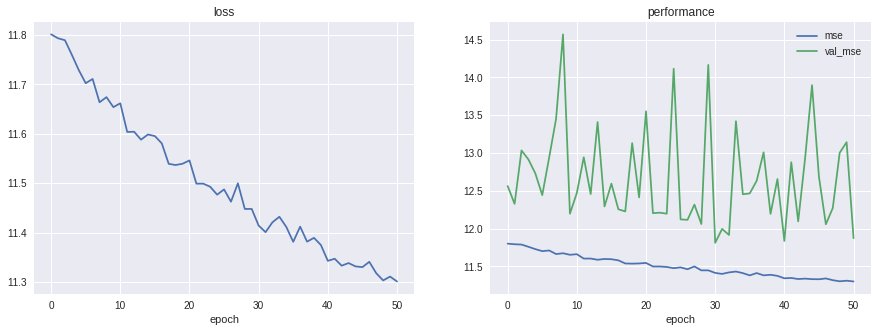

In [0]:
f, ax = plt.subplots(1,2,figsize = [15,5])
ax[0].plot(metrics.history['loss'])
ax[1].plot(metrics.history['mean_squared_error'])
ax[1].plot(metrics.history['val_mean_squared_error'])

ax[0].set_title('loss')
ax[1].set_title('performance')
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[1].legend(['mse','val_mse'], loc='upper right')
plt.show()

In [0]:
# I acutally trained for 34 epochs and then resumed
# training after early stopping, finally the model trained for ~84 epochs

# winner weights were those from epochs: 27, 31, 
weights = ['/content/gdrive/My Drive/models/weights-improvement-34-12.21.hdf5',
          '/content/gdrive/My Drive/models/weights-improvement-31-11.81.hdf5',
          '/content/gdrive/My Drive/models/weights-improvement-27-12.12.hdf5']


models = [get_fancy_model_v2(x_train.shape[-1]) for _ in range(len(weights))]

preds = []
for m, w in zip(models, weights):
  m.load_weights(w)
  preds.append(m.predict(x_test))

In [0]:
shape = preds[0].shape
final = np.zeros(shape)

for p in preds:
    final += p
  
final = final / 3

In [0]:
submission = pd.DataFrame(
    {'key': df_test['key'].values, 'fare_amount': final.squeeze()},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)